In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')
## fred = Fred(api_key='MY API KEY')
## FED API KEY 발급받기
## https://yenpa.tistory.com/65

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf

## DataLoad

In [3]:
## 필수 데이터

## 사전에 획득한 금, 다우존스배당지수
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
## DFF: Federal Funds Rate, DTB3: 3개월 미국 국채 금리, DGS2: 2년 미국 국채 금리, DGS10: 10년 미국 국채 금리, DGS20: 20년 미국 국채 금리
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')
## rec = fred.get_series('USREC').fillna(method='pad') ## 월간 경기침체 데이터 ## 별도 수집 데이터로 대체

## 기본지수 데이터
## ^IXIC : 나스닥종합주가지수, ^GSPC: S&P500지수, ^DJI: 다우존스지수, GC=F : 금선물지수
tickers = ['^IXIC', '^GSPC', '^DJI', 'GC=F']
df_ref = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ref = df_ref['Close']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div'].copy()
df_ref['Gold'] = gold['Gold'].copy()
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

[*********************100%%**********************]  4 of 4 completed


## Preprocessing

In [4]:
## Imputation
df_ref_imp = mf.imputation(df_ref, '^GSPC', '^DJI') ## S&P500를 기준으로 다우존스 지수 보간
df_ref_imp = mf.imputation(df_ref_imp, '^DJI', 'Div') ## 다우존스 지수를 기준으로 배당지수 보간
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS20', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS20', 'DGS10', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS2', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS2', 'DTB3', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'GC=F', 'Gold') ## 금 선물 가격을 기준으로 금 가격 보간
## column selection
df_ref_imp = df_ref_imp[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]

0.9184546401235845
0.8698779253276531
0.8863397424764103
1.0152922092161072
0.6603049190760372
0.7090634224581861
0.9953424146502147


In [5]:
df_ref_scaled = df_ref_imp.copy()
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref_scaled[_cols] = df_ref_scaled[_cols]/df_ref_scaled[_cols].iloc[0] * 100
df_ref_scaled.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref_scaled['Cash'] = (df_ref_scaled['DTB3']/100 * 1/252 + 1).shift(1).fillna(1).cumprod() * 100

In [7]:
## 데이터 임시 저장
df_ref_scaled.to_csv("trend_data.csv", encoding='utf-8-sig')

## Target Data

In [21]:
## 프로젝트마다 필요한 데이터
tickers = ['SCHD', 'SPY', 'QQQ', 'TQQQ', 'TLT', 'SGOV', 'IAU']
df_ori = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ori = df_ori['Close']

[*********************100%%**********************]  7 of 7 completed


In [22]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref_scaled, df_ori], axis=1)
df_imp = mf.imputation(df_imp, 'Div', 'SCHD')
df_imp = mf.imputation(df_imp, 'S&P500', 'SPY')
df_imp = mf.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = mf.imputation(df_imp, 'QQQ', 'TQQQ')
df_imp = mf.imputation(df_imp, 'DGS20', 'TLT')
df_imp = mf.imputation(df_imp, 'Cash', 'SGOV')
df_imp = mf.imputation(df_imp, 'Gold', 'IAU')
df_imp = df_imp[tickers]
df_imp = df_imp/df_imp.iloc[0] * 100

0.9951167220103883
0.993617542348069
1.0445840538283133
2.9807937469683505
-0.3038235982223406
1.023140476195515
0.8731953391003245


In [23]:
## 데이터 임시 저장
df_imp.to_csv("trend_data.csv", encoding='utf-8-sig')

## Visualization(Basic)

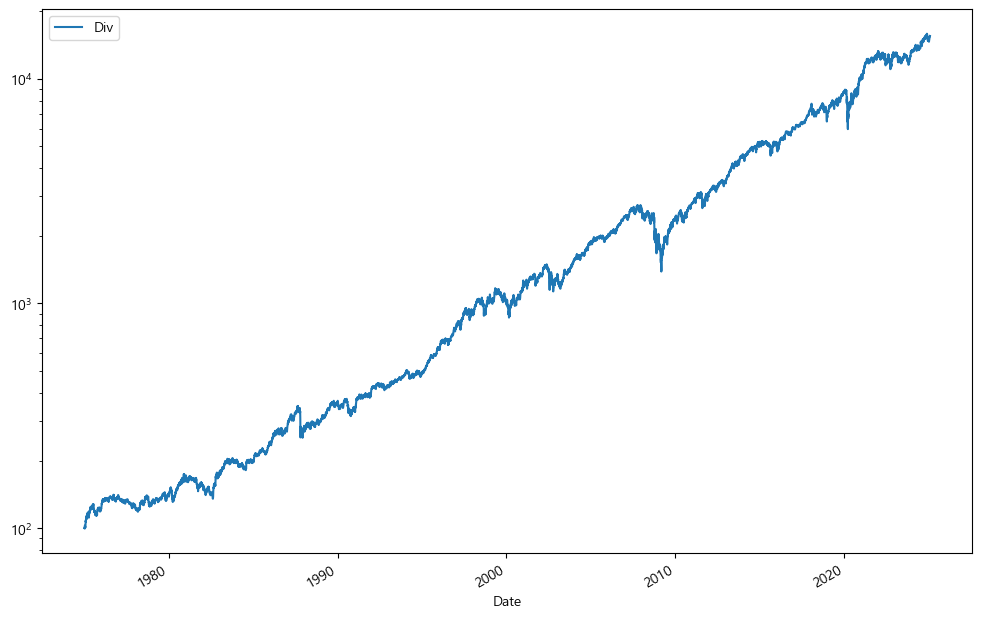

In [12]:
df_ref_scaled[['Div']].plot()
plt.yscale('log')
plt.show()

## gm.trend_plot(df_ref_scaled, ['Div'])

<Axes: ylabel='Frequency'>

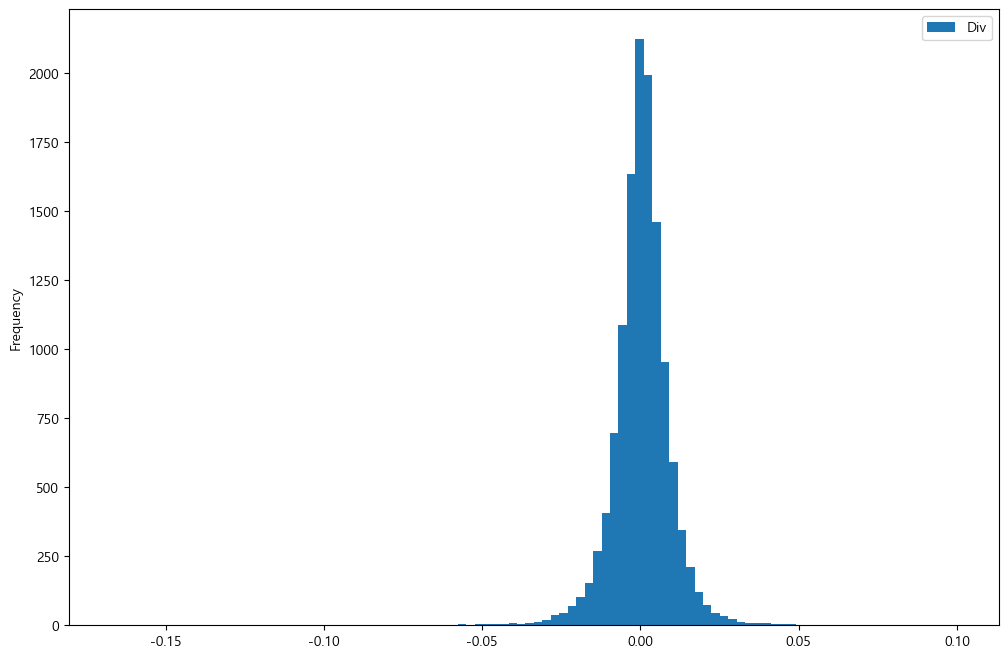

In [16]:
df_ref_scaled[['Div']].pct_change().plot(kind='hist', bins=100)
## gm.asset_histogram_plot(df_ref_scaled.pct_change(), ['Div'])

In [22]:
## MDD 계산
data = df_ref_scaled['Div'].copy()
peak = data.expanding(min_periods=1).max()
drawdown = (data - peak) / peak

<Axes: xlabel='Date'>

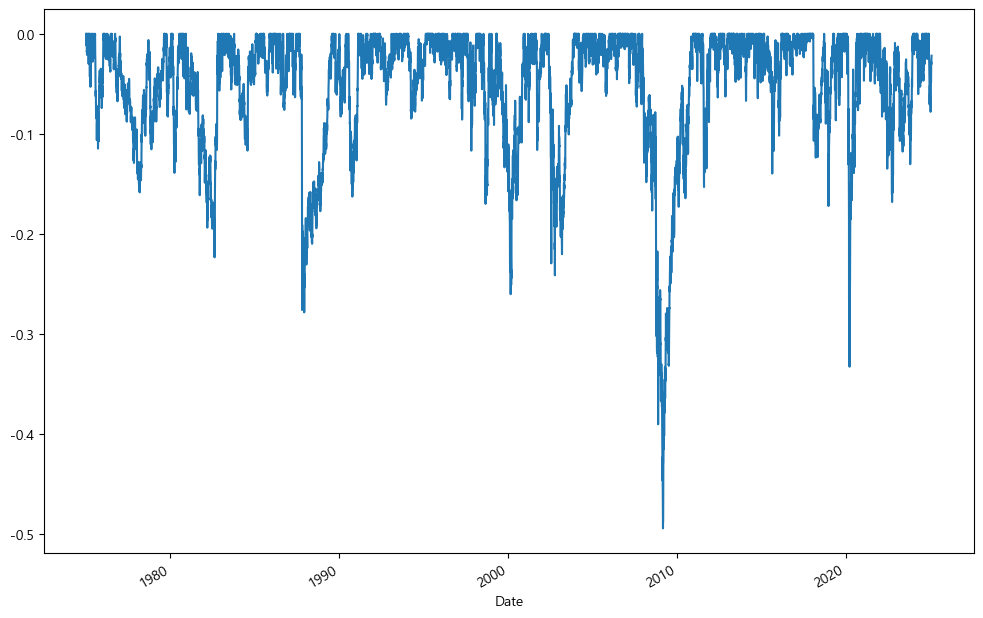

In [25]:
drawdown.plot()
## gm.drawdown_plot(df_ref_scaled, ['Div'])

<Axes: >

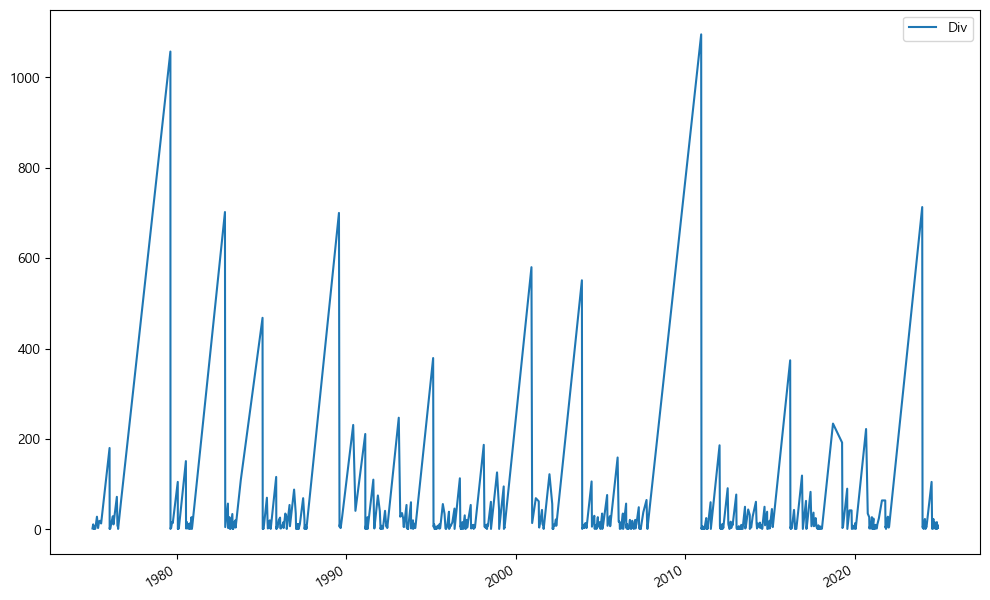

In [30]:
## ttr 계산
ttr_df = mf.get_ttr_df(df_ref_scaled, ['Div'])
ttr_df.plot()
## gm.ttr_plot(ttr_df, ['Div'])

<Axes: >

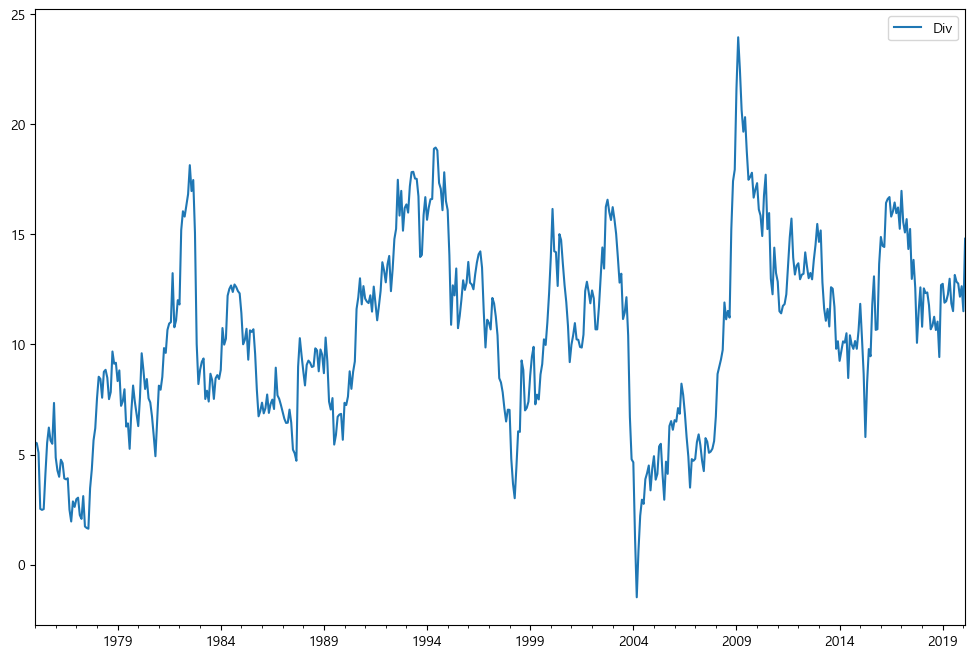

In [32]:
rr_df = mf.get_rr_df(df_ref_scaled, ['Div'])
rr_df.plot()
## gm.rr_trend_plot(rr_df, ['Div'])

<Axes: >

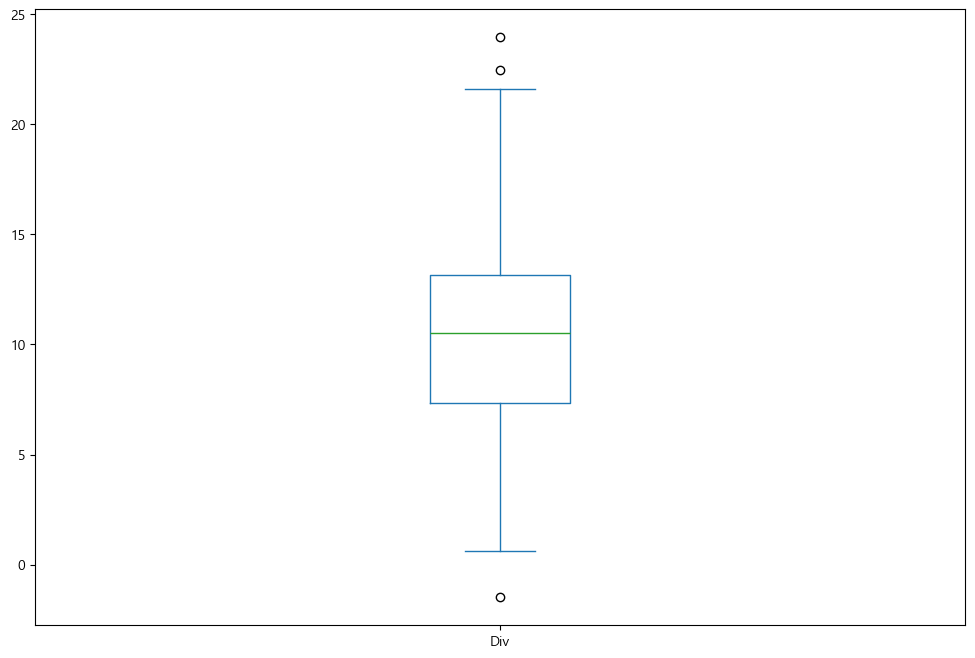

In [34]:
rr_df.plot(kind='box')
## gm.rr_box_plot(rr_df, ['Div'])